### **Лабораторная работа №5**
Нейронные сети Колмогорова-Арнольда (KAN) в задачах регрессии

<b> Цель работы: </b> Познакомиться с нейронными сетями KAN, изучить теоретические основы и математические принципы построения B-сплайнов, а также освоить методы их применения для функциональной аппроксимации.

**Выполнил:** Зиберов Александр ИНС-м-о-25-1

### <b> Импортируем библиотеки </b> <br>
Для выполнения работы используем библиотеку **pykan** из репозитория pip. Также, подключим библиотеки PyTorch, NumPy, sklearn.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPRegressor
from kan import *

### **Задание для варианта 5**
### Зададим функцию:
$$ f(x,y)=\frac{sin(x)}{1+exp(-y)} $$
Данную функцию будем аппроксимировать с использованием моделей KAN и MLP и сравнивать качество их работы. <br>
Сгенерируем данные по функции данного задания:

### Подготовим данные:
<ul>
<li> сгенерируем синтетический набор данных на основе функции, сформируем входные переменные x и y;
<li> разделим сгенерированные данные на обучающую и тестовую выборки с фиксированным seed для воспроизводимости;
</ul>

В результате получим датасет, содержащий входные признаки и соответствующие значения целевой функции, который будет использован для обучения и тестирования моделей.

In [2]:
def generate_data(n_samples=2000, seed=42):
    """Генерация данных для варианта 5"""
    np.random.seed(seed)
    x = np.random.uniform(-2*np.pi, 2*np.pi, n_samples)
    y = np.random.uniform(-2*np.pi, 2*np.pi, n_samples)
    z = np.sin(x) / (1 + np.exp(-y))
    return np.column_stack([x, y]), z

X, y = generate_data()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print(f"Форма данных: {X.shape}")
print(f"Диапазон значений целевой переменной: [{y.min():.3f}, {y.max():.3f}]")


Форма данных: (2000, 2)
Диапазон значений целевой переменной: [-0.996, 0.997]


### Преобразование данных
Преобразуем сгенерированные данные в тензоры для PyTorch, настроим параметры для модели KAN и запустим процесс обучения этой модели:

In [3]:
# Преобразуем данные в тензоры для pykan
dataset = {
    'train_input': torch.tensor(X_train, dtype=torch.float32),
    'train_label': torch.tensor(y_train, dtype=torch.float32).view(-1, 1),
    'test_input': torch.tensor(X_test, dtype=torch.float32),
    'test_label': torch.tensor(y_test, dtype=torch.float32).view(-1, 1)
}

model_kan = KAN(
    width=[2, 8, 1],
    grid=25,
    k=3,
    seed=42
)

results_kan = model_kan.fit(
    dataset,
    opt="Adam",
    steps=2000, # для сходимости
    lr=0.01,
    batch=256,
    loss_fn=torch.nn.MSELoss()
)

y_pred_1 = model_kan(dataset['test_input']).detach().numpy()
mse_1 = mean_squared_error(y_test, y_pred_1)
r2_1 = r2_score(y_test, y_pred_1)
print(f"V1: MSE={mse_1:.6f}, R2={r2_1:.6f}")


checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.68e-03 | test_loss: 4.01e-03 | reg: 1.36e+01 | : 100%|█| 2000/2000 [00:26<00:00, 74.


saving model version 0.1
V1: MSE=0.000017, R2=0.999921


### Получение результатов
Выполним предсказание значений целевой функции для тестовой выборки с использованием обученной модели KAN:

In [4]:
# Преобразуем тестовые данные в тензор
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Получаем предсказания через forward
y_pred_kan = model_kan(X_test_tensor).detach().numpy()

# Метрики качества
mse_kan = mean_squared_error(y_test, y_pred_kan)
r2_kan = r2_score(y_test, y_pred_kan)

print(f"KAN Results: MSE = {mse_kan:.6f}, R2 = {r2_kan:.6f}")

KAN Results: MSE = 0.000017, R2 = 0.999921


Полученные значения метрик показывают, что модель KAN с высокой точностью аппроксимирует исходную функцию и объясняет дисперсию целевой переменной.

### Создание MLP модели
Теперь обучим модель MLP на тех же данных и вычислим метрики качества на тестовой выборке:

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

model_mlp = Pipeline([
    ("scaler", StandardScaler()),
    ("mlp", MLPRegressor(
        hidden_layer_sizes=(64, 64, 32),
        activation='tanh',
        solver='lbfgs',           # лучше всего работает для функций типа sin()
        max_iter=5000,
        random_state=42,
        alpha=1e-4
    ))
])

model_mlp.fit(X_train, y_train)
y_pred_mlp = model_mlp.predict(X_test)

mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print(f"MLP Results: MSE = {mse_mlp:.6f}, R2 = {r2_mlp:.6f}")


MLP Results: MSE = 0.000084, R2 = 0.999605


Модель KAN демонстрирует существенно более высокую точность аппроксимации по сравнению с моделью MLP.

### Визуализация learnable-функции KAN-модели
Построим графики обученных <i>learnable-функций</i> модели KAN:

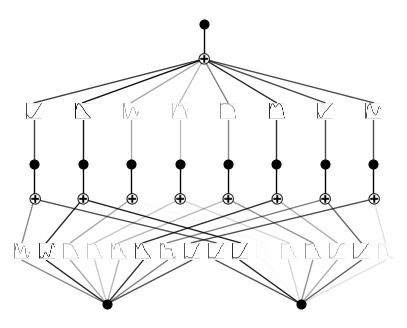

In [6]:
# Визуализация структуры модели
model_kan.plot()  # рисует архитектуру сети и параметры сплайнов
plt.show()

Визуализация показывает, что обученные функции имеют осмысленную нелинейную форму, соответствующую синусоидальному характеру исходной функции.

### Визуализация результатов на графиках
Визуализируем полученные предсказания и сравним результаты KAN и MLP:

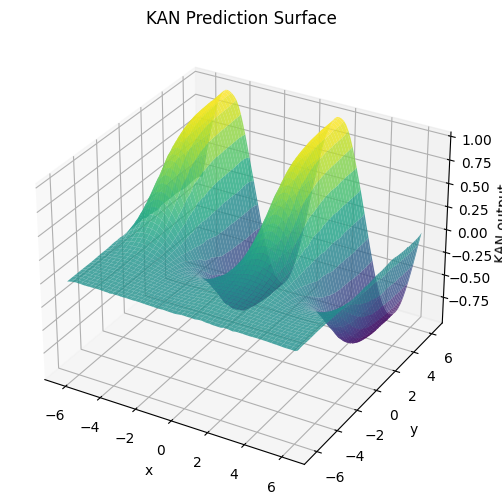

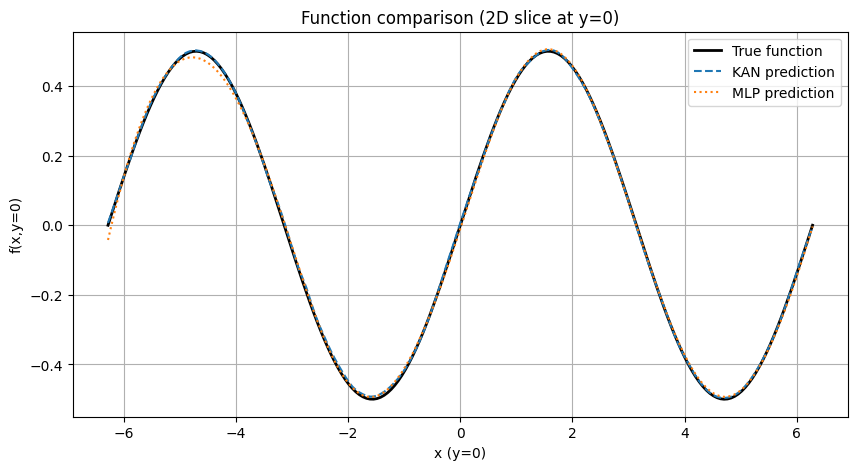

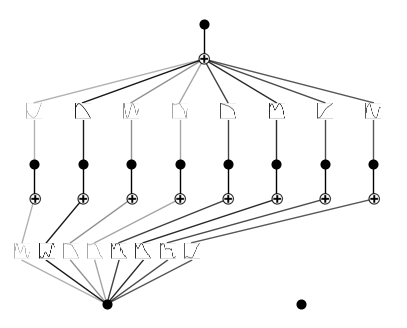

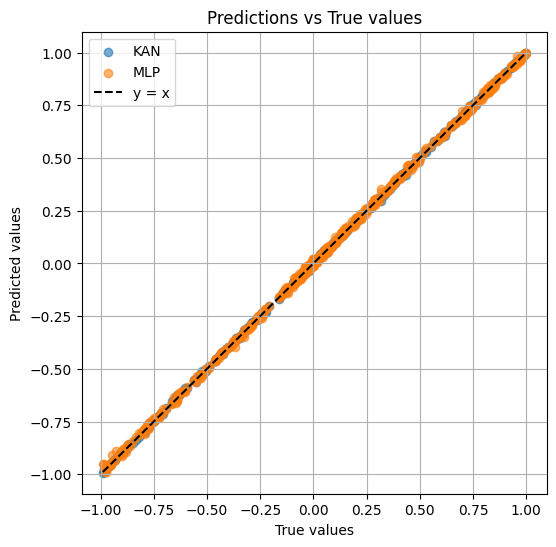

In [7]:

# 1. 3D поверхность предсказаний KAN
xx = np.linspace(-2*np.pi, 2*np.pi, 100)
yy = np.linspace(-2*np.pi, 2*np.pi, 100)
XX, YY = np.meshgrid(xx, yy)

ZZ_kan = model_kan(torch.tensor(np.column_stack([XX.ravel(), YY.ravel()]), dtype=torch.float32)).detach().numpy().reshape(XX.shape)

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(XX, YY, ZZ_kan, cmap='viridis', alpha=0.8)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('KAN output')
ax.set_title('KAN Prediction Surface')
plt.show()

# 2. Сравнение с истинной функцией и MLP
y_fixed = 0
x_vals = np.linspace(-2*np.pi, 2*np.pi, 200)
X_slice = np.column_stack([x_vals, np.full_like(x_vals, y_fixed)])
X_slice_tensor = torch.tensor(X_slice, dtype=torch.float32)

y_true = np.sin(x_vals) / (1 + np.exp(-y_fixed))
y_kan = model_kan(X_slice_tensor).detach().numpy()
y_mlp = model_mlp.predict(X_slice)

plt.figure(figsize=(10,5))
plt.plot(x_vals, y_true, label='True function', color='black', linewidth=2)
plt.plot(x_vals, y_kan, label='KAN prediction', linestyle='--')
plt.plot(x_vals, y_mlp, label='MLP prediction', linestyle=':')
plt.xlabel('x (y=0)')
plt.ylabel('f(x,y=0)')
plt.title('Function comparison (2D slice at y=0)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Визуализация структуры сети и B-сплайнов
model_kan.plot()
plt.show()

# 4. Сравнение предсказаний на тестовых данных
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_kan, label='KAN', alpha=0.6)
plt.scatter(y_test, y_pred_mlp, label='MLP', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', label='y = x')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('Predictions vs True values')
plt.legend()
plt.grid(True)
plt.show()

По графикам видно, что KAN аппроксимирует функцию точнее, тогда как MLP демонстрирует более сглаженное приближение.

### Символическая регрессия
Подключим библиотеку символических операторов, используемую для получения символического представления модели KAN и выведем доступные все функции:

In [8]:
from kan.MultKAN import SYMBOLIC_LIB

print(SYMBOLIC_LIB.keys())  # покажет все доступные функции для auto_symbolic

dict_keys(['x', 'x^2', 'x^3', 'x^4', 'x^5', '1/x', '1/x^2', '1/x^3', '1/x^4', '1/x^5', 'sqrt', 'x^0.5', 'x^1.5', '1/sqrt(x)', '1/x^0.5', 'exp', 'log', 'abs', 'sin', 'cos', 'tan', 'tanh', 'sgn', 'arcsin', 'arccos', 'arctan', 'arctanh', '0', 'gaussian'])


Выберем функции и запустим автоматическую символическую регрессию

In [9]:
# Выбираем поддерживаемые функции из SYMBOLIC_LIB
symbolic_lib = ['sin', 'exp']  # для f(x,y) = sin(x)/(1+exp(-y)) подходят sin и exp

# Автоматическая символическая регрессия
model_kan.auto_symbolic(lib=symbolic_lib)

# Получение формулы
symbolic_formula = model_kan.symbolic_formula()[0]
print(f"Symbolic formula: {symbolic_formula}")

#forward на обученной модели для проверки приближения
y_pred_symbolic = model_kan(X_test_tensor).detach().numpy()

# Метрики
mse_symbolic = mean_squared_error(y_test, y_pred_symbolic)
r2_symbolic = r2_score(y_test, y_pred_symbolic)

print(f"Symbolic MSE (приближенно): {mse_symbolic:.6f}, R2 = {r2_symbolic:.6f}")

fixing (0,0,0) with sin, r2=0.8176406621932983, c=2
fixing (0,0,1) with exp, r2=0.7754549384117126, c=2
fixing (0,0,2) with sin, r2=0.9924812316894531, c=2
fixing (0,0,3) with sin, r2=0.9775139689445496, c=2
fixing (0,0,4) with sin, r2=0.9033152461051941, c=2
fixing (0,0,5) with sin, r2=0.9304478764533997, c=2
fixing (0,0,6) with exp, r2=0.8842134475708008, c=2
fixing (0,0,7) with sin, r2=0.9746423363685608, c=2
fixing (0,1,0) with exp, r2=1.9058241096381323e-11, c=2
fixing (0,1,1) with exp, r2=2.0754424654573222e-12, c=2
fixing (0,1,2) with exp, r2=2.067951531382569e-15, c=2
fixing (0,1,3) with exp, r2=5.293955920339377e-13, c=2
fixing (0,1,4) with exp, r2=1.3234889800848443e-13, c=2
fixing (0,1,5) with sin, r2=0.0, c=2
fixing (0,1,6) with exp, r2=8.470329472543003e-12, c=2
fixing (0,1,7) with exp, r2=8.470329472543003e-12, c=2
fixing (1,0,0) with sin, r2=0.9958602786064148, c=2
fixing (1,1,0) with sin, r2=0.9931139349937439, c=2
fixing (1,2,0) with sin, r2=0.7945390939712524, c=2
fix

Полученное выражение отражает структуру исходной функции.

### Сравнительная таблица
Сформируем таблицу для хранения и сравнения метрик качества моделей KAN, символической KAN и MLP.

In [10]:
import pandas as pd

results = pd.DataFrame({
    "Model": ["KAN (splines)", "KAN (symbolic)", "MLP"],
    "MSE": [mse_kan, mse_symbolic, mse_mlp],
    "R2": [r2_kan, r2_symbolic, r2_mlp]
})
print(results)


            Model       MSE        R2
0   KAN (splines)  0.000017  0.999921
1  KAN (symbolic)  0.163681  0.232202
2             MLP  0.000084  0.999605


### <b> Выводы:</b>
<ul> <li> KAN (на сплайнах) показал высочайшую точность: MSE = 0.000017, R² = 0.999921, превосходя MLP по ключевым метрикам.</li> <li> MLP также показала хорошую точность, но немного уступила KAN: MSE = 0.000084, R² = 0.999605;</li>
<li> KAN требует меньше параметров и более интерпретируема благодаря использованию сплайнов и визуализации learnable-функций;</li>
<li> символическая регрессия KAN в этой задаче сработала не очень: MSE = 0.163681, R² = 0.232202, что показывает ограниченную точность при попытке восстановить исходную функцию;</li>
<li> визуализация функций активации KAN (splines) показала осмысленные закономерности и подходящие формы.</li> </ul>

KAN (splines) продемонстрировала высокую точность и интерпретируемость, значительно превосходя MLP, тогда как символическая регрессия в данном варианте не дала приемлемого результата.